After discussing with my mentor, we've decided that it's best we take an approach of assessing which datasets to use, rather than evaluating the models themselves. Given that the goal of the final project is to compare the performance of various models, it is likely we will include a variety of models regardless of their performance. As such, we will focus this exercise on examining the performance of various datasets.

For this assignment, we will begin with the first data set, which covers a large majority of the data we will be working with, namely time-series data. We first tried FRED data, however realized that it only covered index stocks, and ended up using a different approach from wiki stocks.

For the future, I've laid out two additional datasets to test.

Dataset 1: Time-series stock data (daily)

Dataset 2: Financial news + technical data

Dataset 3: Combination of time-series data + monthly production values (https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb)

Dataset 4: Quandl? https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/data/create_datasets.ipynb

Approaches: 
1. RNN: See existing research
2. ARIMA: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/09_time_series_models/02_arima_models.ipynb
3. Gradient boosting: see stefan jansen
4. K-means (For future): https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/13_unsupervised_learning/03_clustering_algorithms/02_kmeans_implementation.ipynb

<h4> Section 0: Imports </h4>

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


<h4> Section 1: Time-series data from FRED (Federal Reserve Bank's Data Service) </h4>



In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

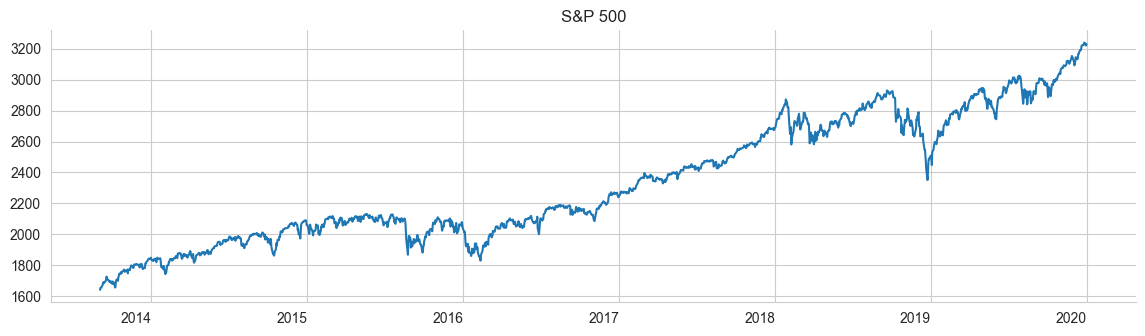

In [4]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [5]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

pd.set_option('display.expand_frame_repr', False)

In [6]:
DATA_STORE = Path('assets.h5')

In [7]:
df = pd.read_csv('data/wiki_stocks.csv')
# no longer needed
# df = pd.concat([df.loc[:, 'code'].str.strip(),
#                 df.loc[:, 'name'].str.split('(', expand=True)[0].str.strip().to_frame('name')], axis=1)

print(df.info)
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/stocks', df)

<bound method DataFrame.info of      ticker                                               name
0         A  Agilent Technologies Inc. (A) Prices, Dividend...
1        AA  Alcoa Inc. (AA) Prices, Dividends, Splits and ...
2       AAL  American Airlines Group Inc. (AAL) Prices, Div...
3      AAMC  Altisource Asset Management (AAMC) Prices, Div...
4       AAN  Aaron's Inc. (AAN) Prices, Dividends, Splits a...
...     ...                                                ...
3176   ZNGA  Zynga Inc. (ZNGA) Prices, Dividends, Splits an...
3177   ZOES  Zoe's Kitchen Inc (ZOES) Prices, Dividends, Sp...
3178    ZQK  Quiksilver Inc. (ZQK) Prices, Dividends, Split...
3179    ZTS  Zoetis Inc (ZTS) Prices, Dividends, Splits and...
3180   ZUMZ  Zumiez Inc. (ZUMZ) Prices, Dividends, Splits a...

[3181 rows x 2 columns]>


In [8]:
df = (pd.read_csv('data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info)

<bound method DataFrame.info of                      open    high     low   close      volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close    adj_volume
date       ticker                                                                                                                                
1962-01-02 ARNC     65.56   65.75   65.38   65.38      5600.0          0.0          1.0   3.458163   3.468185   3.448668   3.448668  4.480000e+04
           BA       50.88   50.88   50.00   50.00     11595.0          0.0          1.0   0.887160   0.887160   0.871816   0.871816  3.521981e+05
           CAT      38.50   38.87   38.12   38.50     13600.0          0.0          1.0   1.578370   1.593539   1.562791   1.578370  1.632000e+05
           DD      241.50  244.25  241.50  241.50      2000.0          0.0          1.0   4.718414   4.772144   4.718414   4.718414  3.600000e+04
           DIS      37.25   38.50   37.25   37.25      2098.0          0.0          1.0   0.

In [9]:
def get_data(start_date, end_date, ticker, df):
    idx = pd.IndexSlice
    new_df = df.loc[idx[start_date:end_date, ticker], :]
    return new_df

In [10]:
DEFAULT_START = '2008-01-01'
DEFAULT_END = '2018-01-01'

AAPL_df = get_data(DEFAULT_START, DEFAULT_END, 'AAPL', df)
AAPL_df.head(5)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
2008-01-02,AAPL,199.27,200.26,192.55,194.84,38542100.0,0.0,1.0,25.608972,25.736201,24.745359,25.039656,269794700.0
2008-01-03,AAPL,195.41,197.39,192.69,194.93,30073800.0,0.0,1.0,25.112909,25.367366,24.763351,25.051222,210516600.0
2008-01-04,AAPL,191.45,193.00,178.89,180.05,51994000.0,0.0,1.0,24.603993,24.803190,22.989858,23.138934,363958000.0
2008-01-07,AAPL,181.25,183.60,170.23,177.64,74006900.0,0.0,1.0,23.293151,23.595159,21.876928,22.829216,518048300.0
2008-01-08,AAPL,180.14,182.46,170.80,171.25,54422000.0,0.0,1.0,23.150501,23.448653,21.950181,22.008012,380954000.0


<h4> Section 2: Time-series data from wiki stocks</h4>


<h4> Section 2.1: RNN Using wiki stocks data </h4>
1. Create univariate data, with a given window size, for our RNN model
2. Train-test split, evaluate model

In [11]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [12]:
dat = AAPL_df.reset_index(level = [1])[['open']]
dat

,open
date,
2008-01-02,199.27
2008-01-03,195.41
2008-01-04,191.45
2008-01-07,181.25
2008-01-08,180.14
...,...
2017-12-22,174.68
2017-12-26,170.80
2017-12-27,170.10


In [13]:
### Normalize Data ###
scaler = MinMaxScaler()
aapl_scaled = pd.Series(scaler.fit_transform(dat).squeeze(), index=dat.index)

window_size = 63

### Create Data ###
X, y = create_univariate_rnn_data(aapl_scaled, window_size=window_size)



In [14]:
### Train-test split ###

X, y = create_univariate_rnn_data(aapl_scaled, window_size=window_size)

### Train on data up to 2018 ###
X_train = X[:'2016'].values.reshape(-1, window_size, 1)
y_train = y[:'2016']

### Test on data from 2019 ###
X_test = X['2017':].values.reshape(-1, window_size, 1)
y_test = y['2017':]

n_obs, window_size, n_features = X_train.shape

y_train.shape

(2204,)

In [15]:
### Create RNN Model ###

rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
### Define optimizer for RNN ###

optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

### Compile RNN w/ previously defined optimizer ###
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

### Save best path of model during training ###
rnn_path = (results_path / 'rnn.h5').as_posix()

### Call best model during training ###
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

### Early stopping to prevent overfitting ###
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

### Train model ###
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=2)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.00007, saving model to results/univariate_time_series\rnn.h5
111/111 - 3s - loss: 0.0215 - val_loss: 6.6148e-05 - 3s/epoch - 29ms/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.00007
111/111 - 1s - loss: 0.0031 - val_loss: 6.6259e-04 - 1s/epoch - 11ms/step
Epoch 3/150

Epoch 3: val_loss improved from 0.00007 to 0.00005, saving model to results/univariate_time_series\rnn.h5
111/111 - 1s - loss: 0.0023 - val_loss: 5.3278e-05 - 1s/epoch - 11ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.00005 to 0.00005, saving model to results/univariate_time_series\rnn.h5
111/111 - 1s - loss: 0.0018 - val_loss: 5.2771e-05 - 1s/epoch - 12ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.00005 to 0.00003, saving model to results/univariate_time_series\rnn.h5
111/111 - 1s - loss: 0.0016 - val_loss: 2.8920e-05 - 1s/epoch - 12ms/step
Epoch 6/150

Epoch 6: val_loss did not improve from 0.00003
111/111 - 1s - loss: 0.0015 - val_loss

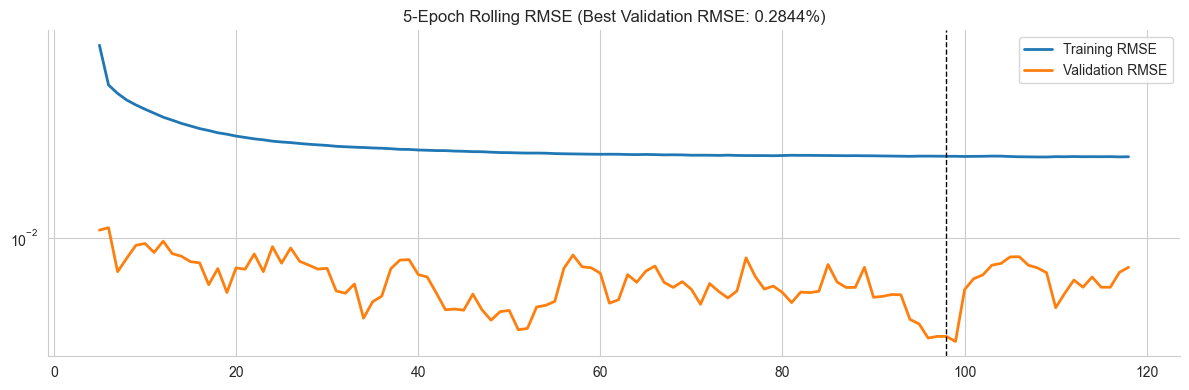

In [17]:
### Plot performance ###

fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300)

In [18]:
### More performance benchmarks ###

train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0216 | Test RMSE: 0.0028


In [19]:
### We trained on scaled data, therefore our predictions are in scaled form ###
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

### Correlation coefficient between predicted and actual values ###
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

8/8 [==============================] - 0s 3ms/step
Train IC: 0.9958 | Test IC: 0.9877


<h4> Section 2.2: ARIMA Using Wiki Stocks data </h4>

1. Use arima and evaluation models from Springboard
2. Evaluate different p, d, and q values on a smaller dataset to identify optimal values.
3. Train larger dataset on optimal p, d, and q values, and evaluate results.

In [10]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [11]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.10f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.10f' % (best_cfg, best_score))

In [12]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [14]:
NEW_START = '2017-01-01'
NEW_END = '2018-01-01'

AAPL_ARIMA_df = get_data(NEW_START, NEW_END, 'AAPL', df)
AAPL_ARIMA_df.head(5)

,,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,ticker,,,,,,,,,,,,
2017-01-03,AAPL,115.80,116.3300,114.76,116.15,28781865.0,0.0,1.0,114.369701,114.893155,113.342546,114.715378,28781865.0
2017-01-04,AAPL,115.85,116.5100,115.75,116.02,21118116.0,0.0,1.0,114.419083,115.070931,114.320318,114.586983,21118116.0
2017-01-05,AAPL,115.92,116.8642,115.81,116.61,22193587.0,0.0,1.0,114.488219,115.420756,114.379577,115.169696,22193587.0
2017-01-06,AAPL,116.78,118.1600,116.47,117.91,31751900.0,0.0,1.0,115.337596,116.700551,115.031425,116.453639,31751900.0
2017-01-09,AAPL,117.95,119.4300,117.94,118.99,33561948.0,0.0,1.0,116.493145,117.954865,116.483269,117.520300,33561948.0


In [15]:
arima_dat = AAPL_ARIMA_df.reset_index(level = [1])['open']
arima_log = np.log(arima_dat)
arima_log

date
2017-01-03    4.751865
2017-01-04    4.752296
2017-01-05    4.752900
2017-01-06    4.760292
2017-01-09    4.770261
                ...   
2017-12-22    5.162956
2017-12-26    5.140493
2017-12-27    5.136386
2017-12-28    5.141664
2017-12-29    5.138853
Name: open, Length: 249, dtype: float64

In [16]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(arima_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0206729848
ARIMA(0, 0, 1) MSE=0.0061096211
ARIMA(0, 0, 2) MSE=0.0023212021
ARIMA(0, 1, 0) MSE=0.0001415116
ARIMA(0, 1, 1) MSE=0.0001432954
ARIMA(0, 1, 2) MSE=0.0001456522
ARIMA(0, 2, 0) MSE=0.0002719677
ARIMA(0, 2, 1) MSE=0.0001411507
ARIMA(0, 2, 2) MSE=0.0001439524
ARIMA(1, 0, 0) MSE=0.0001431367
ARIMA(1, 0, 1) MSE=0.0001457899
ARIMA(1, 0, 2) MSE=0.0001482417
ARIMA(1, 1, 0) MSE=0.0001430941
ARIMA(1, 1, 1) MSE=0.0001425721
ARIMA(1, 1, 2) MSE=0.0001454535
ARIMA(1, 2, 0) MSE=0.0002018136
ARIMA(1, 2, 1) MSE=0.0001449130
ARIMA(1, 2, 2) MSE=0.0001550109
ARIMA(2, 0, 0) MSE=0.0001439018
ARIMA(2, 0, 1) MSE=0.0001500149
ARIMA(2, 0, 2) MSE=0.0001463003
ARIMA(2, 1, 0) MSE=0.0001452486
ARIMA(2, 1, 1) MSE=0.0001443384
ARIMA(2, 1, 2) MSE=0.0001466745
ARIMA(2, 2, 0) MSE=0.0001716966
ARIMA(2, 2, 1) MSE=0.0001476157
ARIMA(2, 2, 2) MSE=0.0001541703
Best ARIMA(0, 2, 1) MSE=0.0001411507


In [18]:
AAPL_ARIMA_START = '2010-01-01'
AAPL_ARIMA_END = '2018-01-01'

AAPL_ARIMA_df = get_data(AAPL_ARIMA_START, AAPL_ARIMA_END, 'AAPL', df)
AAPL_ARIMA_df.head(5)

arima_dat = AAPL_ARIMA_df.reset_index(level = [1])['open']
arima_log = np.log(arima_dat)
arima_log

date
2010-01-04    5.363309
2010-01-05    5.368776
2010-01-06    5.367750
2010-01-07    5.355406
2010-01-08    5.348535
                ...   
2017-12-22    5.162956
2017-12-26    5.140493
2017-12-27    5.136386
2017-12-28    5.141664
2017-12-29    5.138853
Name: open, Length: 2011, dtype: float64

In [19]:
p=0
d=2
q=1
model = ARIMA(arima_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                 2011
Model:                 ARIMA(0, 2, 1)   Log Likelihood                3294.570
Date:                Fri, 01 Sep 2023   AIC                          -6585.139
Time:                        15:31:27   BIC                          -6573.928
Sample:                             0   HQIC                         -6581.024
                               - 2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.507     -1.973      0.048      -1.993      -0.007
sigma2         0.0022      0.001      1.988      0.047    3.14e-05       0.004
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):         184269347.48
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                           -35.72
Prob(H) (two-sided):                  0.10   Kurtosis:                      1484.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

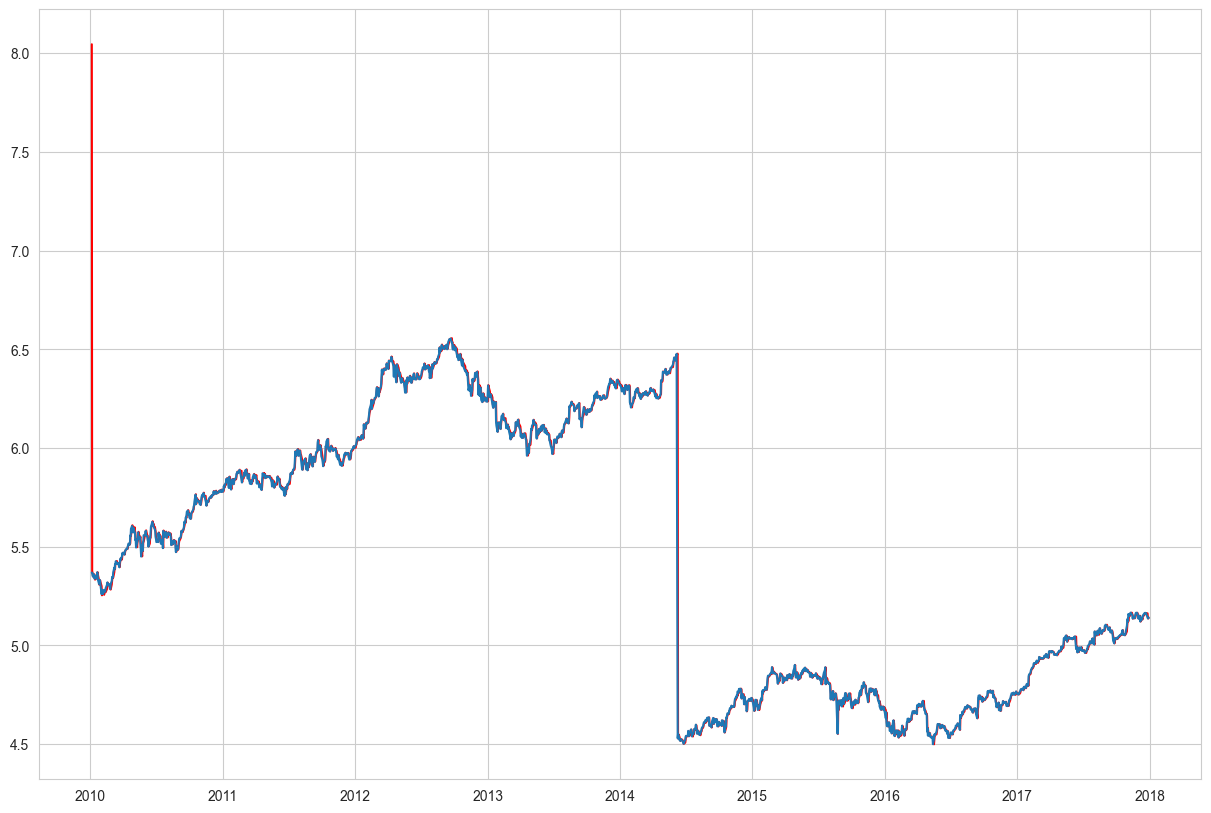

In [28]:
preds = model_fit.predict()

plt.figure(figsize=(15,10))
plt.plot(preds[1:], color = 'red')
plt.plot(arima_log[1:])


In [31]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'ex-dividend', 'split_ratio',
       'adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume'],
      dtype='object')

<h4> Section 2.3: Gradient Boosting using Wiki stocks data </h4>
1. Section data into 10 years and configure for training
2. Train test split
3. See results

In [66]:
AAPL_START = '2008-01-01'
AAPL_END = '2018-01-01'

AAPL_GB_df = get_data(AAPL_START, AAPL_END, 'AAPL', df)
AAPL_GB_df.head(5)

gb_dat = AAPL_GB_df.reset_index(level = [1])['open']

gb_df = gb_dat.reset_index()
gb_df.columns = ['date', 'open']

gb_df['timestamp'] = (gb_df['date'].astype('int64') // 10**9).astype('int32')
gb_df = gb_df[['open', 'timestamp']]
gb_df

,open,timestamp
0,199.27,1199232000
1,195.41,1199318400
2,191.45,1199404800
3,181.25,1199664000
4,180.14,1199750400
...,...,...
2511,174.68,1513900800
2512,170.80,1514246400
2513,170.10,1514332800
2514,171.00,1514419200


In [67]:
from sklearn.model_selection import train_test_split

dataset = gb_df.values
X = dataset[:,1].reshape(-1,1)
Y = dataset[:,0:1]

validation_size = 0.15
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [68]:
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01}
model = ensemble.GradientBoostingRegressor(**params)
model.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500)

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(X_train, Y_train)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ',model_score)
y_predicted = model.predict(X_validation)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(Y_validation, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(Y_validation, y_predicted))

R2 sq:  0.9972223384645568
Mean squared error: 72.58
Test Variance score: 1.00
